In [13]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
#1. Data Setup & Exploration(Connect to the database using Python)
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

In [15]:
cursor.execute('''
CREATE TABLE patients (
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    age INTEGER NOT NULL,
    gender TEXT NOT NULL
)
''')
conn.commit()

In [16]:

cursor.execute('''
CREATE TABLE visits (
  visit_id INTEGER PRIMARY KEY,
    patient_id INTEGER,
    visit_date TEXT,
    doctor_id INTEGER,
    diagnosis_code TEXT,
    FOREIGN KEY (patient_id) REFERENCES patients(id),
    FOREIGN KEY (doctor_id) REFERENCES doctors(doctor_id),
    FOREIGN KEY (diagnosis_code) REFERENCES diagnoses(diagnosis_code)
)
''')
conn.commit()

cursor.execute('''
CREATE TABLE doctors (
    doctor_id INTEGER PRIMARY KEY,
    name TEXT,
    department TEXT
);
''')


cursor.execute('''
CREATE TABLE treatments (
    treatment_id INTEGER PRIMARY KEY,
    visit_id INTEGER,
    treatment_name TEXT,
    treatment_cost REAL,
    FOREIGN KEY (visit_id) REFERENCES visits(visit_id)
);
''')


cursor.execute('''
CREATE TABLE diagnoses (
    diagnosis_code TEXT PRIMARY KEY,
    diagnosis_description TEXT
);
''')


In [17]:
#Inserting Data Into Tables
cursor.executemany('''
INSERT INTO patients (id, name, age, gender)
VALUES (?, ?, ?, ?)
''', [
    (1, 'Alice', 25, 'F'),
    (2, 'Bob', 30, 'M'),
    (3, 'Charlie', 35, 'M')
])


cursor.executemany('''
INSERT INTO doctors (doctor_id, name, department)
VALUES (?, ?, ?)
''', [
    (1, 'Dr. Smith', 'Cardiology'),
    (2, 'Dr. Johnson', 'Neurology')
])


cursor.executemany('''
INSERT INTO diagnoses (diagnosis_code, diagnosis_description)
VALUES (?, ?)
''', [
    ('D001', 'Flu'),
    ('D002', 'Cold'),
    ('D003', 'Headache')
])

cursor.executemany('''
INSERT INTO visits (visit_id, patient_id, visit_date, doctor_id, diagnosis_code)
VALUES (?, ?, ?, ?, ?)
''', [
    (1, 1, '2023-01-01', 1, 'D001'),
    (2, 2, '2023-01-02', 2, 'D002'),
    (3, 3, '2023-01-03', 1, 'D003')
])

# Insert data into the treatments table
cursor.executemany('''
INSERT INTO treatments (treatment_id, visit_id, treatment_name, treatment_cost)
VALUES (?, ?, ?, ?)
''', [
    (1, 1, 'Antibiotics', 50.0),
    (2, 2, 'Cough Syrup', 20.0),
    (3, 3, 'Painkillers', 30.0)
])

conn.commit()

In [18]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table_name, in tables:
    print(f"Data from table: {table_name}")
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    print(df)
    print("\n")

Data from table: patients
   id     name  age gender
0   1    Alice   25      F
1   2      Bob   30      M
2   3  Charlie   35      M


Data from table: visits
   visit_id  patient_id  visit_date  doctor_id diagnosis_code
0         1           1  2023-01-01          1           D001
1         2           2  2023-01-02          2           D002
2         3           3  2023-01-03          1           D003


Data from table: doctors
   doctor_id         name  department
0          1    Dr. Smith  Cardiology
1          2  Dr. Johnson   Neurology


Data from table: treatments
   treatment_id  visit_id treatment_name  treatment_cost
0             1         1    Antibiotics            50.0
1             2         2    Cough Syrup            20.0
2             3         3    Painkillers            30.0


Data from table: diagnoses
  diagnosis_code diagnosis_description
0           D001                   Flu
1           D002                  Cold
2           D003              Headache




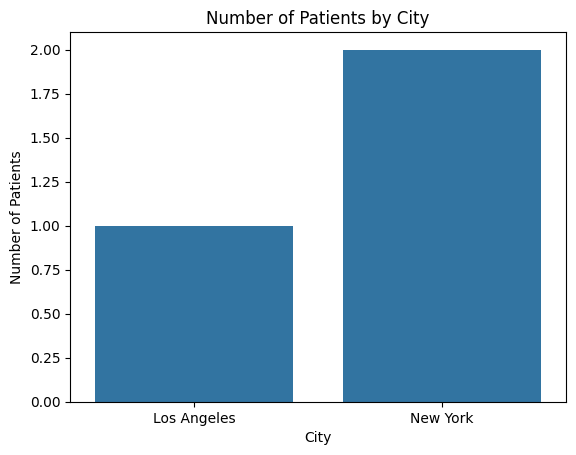

In [19]:
#Number of patients by city.
cursor.execute('ALTER TABLE patients ADD COLUMN city TEXT')
cursor.executemany('''
UPDATE patients
SET city = ?
WHERE id = ?
''', [
    ('New York', 1),
    ('Los Angeles', 2),
    ('New York', 3)
])
conn.commit()


query = '''
SELECT city, COUNT(*) as patient_count
FROM patients
GROUP BY city
'''
city_data = pd.read_sql_query(query, conn)


sns.barplot(data=city_data, x='city', y='patient_count')
plt.title('Number of Patients by City')
plt.xlabel('City')
plt.ylabel('Number of Patients')
plt.show()

In [ ]:
#2. Diagnosis Trends by Department

query = '''
SELECT d.department, COUNT(v.diagnosis_code) AS diagnosis_count
FROM visits v
JOIN doctors d ON v.doctor_id = d.doctor_id
GROUP BY d.department
'''
diagnosis_trends = pd.read_sql_query(query, conn)
print(diagnosis_trends)

#JOINING TABLES
query = '''
SELECT v.visit_id, v.visit_date, p.name AS patient_name, d.name AS doctor_name, 
    d.department, diag.diagnosis_description
FROM visits v
JOIN patients p ON v.patient_id = p.id
JOIN doctors d ON v.doctor_id = d.doctor_id
JOIN diagnoses diag ON v.diagnosis_code = diag.diagnosis_code
'''
results_df = pd.read_sql_query(query, conn)
print(results_df)

#INTERPRETATION
#The data shows that the Cardiology department handled 2 diagnoses, while the Neurology department handled 1 diagnosis
#The detailed visit information provides insights into each visit, including the visit date, patient name, doctor name, department, and diagnosis description:

#On 2023-01-01, Alice visited Dr. Smith in the Cardiology department and was diagnosed with Flu.
#On 2023-01-02, Bob visited Dr. Johnson in the Neurology department and was diagnosed with Cold.
#On 2023-01-03, Charlie visited Dr. Smith in the Cardiology department and was diagnosed with Headach



   department  diagnosis_count
0  Cardiology                2
1   Neurology                1
   visit_id  visit_date patient_name  doctor_name  department  \
0         1  2023-01-01        Alice    Dr. Smith  Cardiology   
1         2  2023-01-02          Bob  Dr. Johnson   Neurology   
2         3  2023-01-03      Charlie    Dr. Smith  Cardiology   

  diagnosis_description  
0                   Flu  
1                  Cold  
2              Headache  


  patient_name  total_treatment_cost
0        Alice                  50.0
1          Bob                  20.0
2      Charlie                  30.0


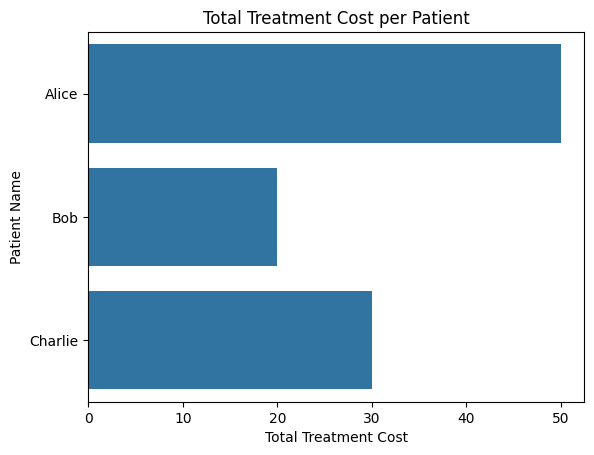

In [21]:
#3. Cost Analysis per Patient
query = '''
SELECT p.name AS patient_name, SUM(t.treatment_cost) AS total_treatment_cost
FROM treatments t
JOIN visits v ON t.visit_id = v.visit_id
JOIN patients p ON v.patient_id = p.id
GROUP BY p.name
'''
treatment_costs = pd.read_sql_query(query, conn)
print(treatment_costs)

sns.barplot(data=treatment_costs, x='total_treatment_cost', y='patient_name', orient='h')
plt.title('Total Treatment Cost per Patient')
plt.xlabel('Total Treatment Cost')
plt.ylabel('Patient Name')
plt.show()


In [22]:
#4. Data Quality & Anomaly Detection

query_duplicates = '''
SELECT name, gender, COUNT(*) as count
FROM patients
GROUP BY name, gender
HAVING count > 1
'''
duplicate_patients = pd.read_sql_query(query_duplicates, conn)
print("Duplicate Patients:")
print(duplicate_patients)

query_invalid_treatments = '''
SELECT *
FROM treatments
WHERE treatment_cost <= 0
'''
invalid_treatments = pd.read_sql_query(query_invalid_treatments, conn)
print("\nInvalid Treatments:")
print(invalid_treatments)

if not duplicate_patients.empty:
    print("\nHandling duplicate patient records...")
    patients_df.drop_duplicates(subset=['name', 'gender'], keep='first', inplace=True)
    print("Duplicates removed. Updated patients data:")
    print(patients_df)
else:
    print("\nNo duplicate patient records found.")

if not invalid_treatments.empty:
    print("\nHandling invalid treatment costs...")
    for index, row in invalid_treatments.iterrows():
        cursor.execute('DELETE FROM treatments WHERE treatment_id = ?', (row['treatment_id'],))
    conn.commit()
    print("Invalid treatments removed.")
else:
    print("\nNo invalid treatment costs found.")

Duplicate Patients:
Empty DataFrame
Columns: [name, gender, count]
Index: []

Invalid Treatments:
Empty DataFrame
Columns: [treatment_id, visit_id, treatment_name, treatment_cost]
Index: []

No duplicate patient records found.

No invalid treatment costs found.


Patients with more than 5 visits in the last year:
Empty DataFrame
Columns: [patient_name, visit_count]
Index: []

Visit frequency across months:
  visit_month  visit_count
0     2023-01            3


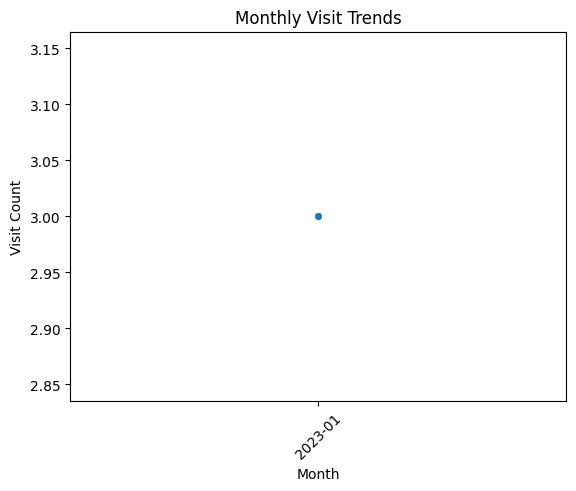

In [23]:
#5. Advanced Insight – Frequent Patients & Visit Patterns

#Identifying patients with more than 5 visits in the last year
query_frequent_patients = """
SELECT p.name AS patient_name, COUNT(v.visit_id) AS visit_count
FROM visits v
JOIN patients p ON v.patient_id = p.id
WHERE v.visit_date >= DATE('now', '-1 year')
GROUP BY p.name
HAVING visit_count > 5
"""
frequent_patients = pd.read_sql_query(query_frequent_patients, conn)
print("Patients with more than 5 visits in the last year:")
print(frequent_patients)

#visit frequency across months
query_monthly_visits = """
SELECT strftime('%Y-%m', visit_date) AS visit_month, COUNT(visit_id) AS visit_count
FROM visits
GROUP BY visit_month
ORDER BY visit_month
"""
monthly_visits = pd.read_sql_query(query_monthly_visits, conn)
print("\nVisit frequency across months:")
print(monthly_visits)

sns.lineplot(data=monthly_visits, x='visit_month', y='visit_count', marker='o')
plt.title('Monthly Visit Trends')
plt.xlabel('Month')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.show()

